# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Business Understanding (Problem Statement)

#### Q1. What kind of offers does Starbucks provide? What characristics does each offer type have? 
#### Q2. What are the demographic characteristics of members?
#### Q3. How different do people react to the different promotion offers(transaciton characteristics)?
#### Q4. Can we build a prediction engine to help determine what offer we should send to each customer? 

# Data Understanding -- EDA

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, fbeta_score, recall_score,confusion_matrix, classification_report \
,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## portfolio dataset

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

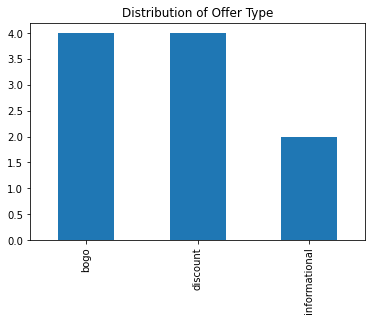

In [7]:
# Count offers by offer type
portfolio['offer_type'].value_counts().plot.bar(title='Distribution of Offer Type', color='tab:blue');

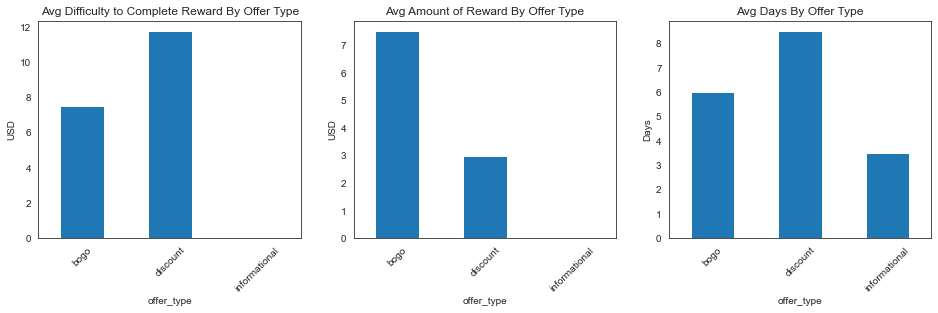

In [8]:
# Explore by offer type

plt.figure(figsize=[16,4])
color = sns.color_palette()[0]
sns.set_style("white")

plt.subplot(1,3,1)
portfolio.groupby('offer_type')['difficulty'].mean().plot(kind='bar', color=color)
plt.title('Avg Difficulty to Complete Reward By Offer Type')
plt.ylabel('USD')
plt.xticks(rotation=45);

plt.subplot(1,3,2)
portfolio.groupby('offer_type')['reward'].mean().plot(kind='bar', color=color)
plt.title('Avg Amount of Reward By Offer Type')
plt.ylabel('USD')
plt.xticks(rotation=45);

plt.subplot(1,3,3)
portfolio.groupby('offer_type')['duration'].mean().plot(kind='bar', color=color)
plt.title('Avg Days By Offer Type')
plt.ylabel('Days')
plt.xticks(rotation=45);

In [9]:
# test = portfolio.join(portfolio.channels.str.join('|').str.get_dummies())
# test.head()

### portfolio dataset EDA Insight

- 10 rows, 6 columns in total
- no missing value and duplicates
- the content of channel column may need to split into columns(4 channels)

## profile dataset

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [12]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
# check duplicates

profile.id.duplicated().sum()

0

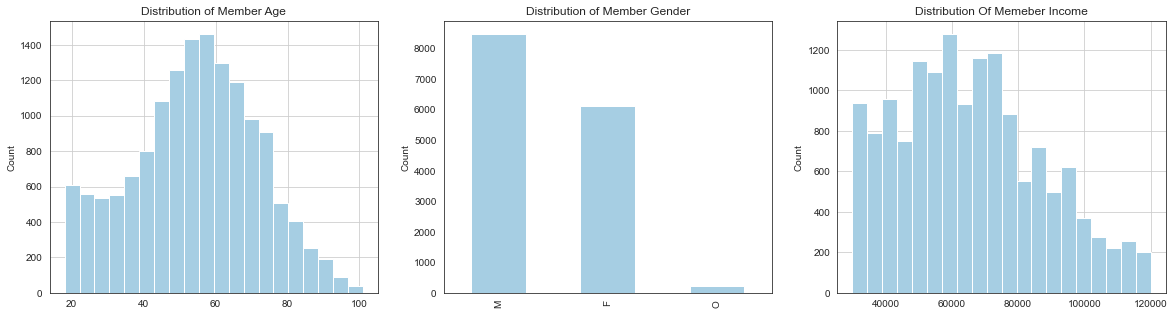

In [62]:
# Explore member distribution

plt.figure(figsize=[20,5])
color = sns.color_palette()[0]
sns.set_style("white")

plt.subplot(1,3,1)
profile['age'].hist(bins=20, color=color)
plt.title('Distribution of Member Age')
plt.ylabel('Count');

plt.subplot(1,3,2)
profile['gender'].value_counts().plot(kind='bar', color=color)
plt.title('Distribution of Member Gender')
plt.ylabel('Count');

plt.subplot(1,3,3)
profile['income'].hist(bins=20, color=color)
plt.title('Distribution Of Memeber Income')
plt.ylabel('Count');

In [16]:
# Check outliers in age

print('The amount of missing values in gender column: {}'.format(profile.gender.isnull().sum()))
print('The amount of missing values in income column: {}'.format(profile.income.isnull().sum()))
print('The number of outliers age in 118: {}'.format(profile[profile.age == 118]['id'].count()))

profile_missing_data = profile[(profile.age == 118) & (profile.gender.isnull()) & (profile.income.isnull())]
print('The number of records which has age in 118 and missing value in both gender and income columns'\
    .format(len(profile_missing_data)))
print('Missing value percentage in the dataset: {:.2f}'.format(len(profile_missing_data) / profile.shape[0]))
profile_missing_data.sample(3)


The amount of missing values in gender column: 2175
The amount of missing values in income column: 2175
The number of outliers age in 118: 2175
The number of records which has age in 118 and missing value in both gender and income columns
Missing value percentage in the dataset: 0.13


,gender,age,id,became_member_on,income
5990,None,118,47abadbaaee341bb88b46de222ba4a39,20170730,NaN
26,None,118,65aba5c617294649aeb624da249e1ee5,20170330,NaN
15644,None,118,4911462378c34cefa51ddbc0cf9f22c6,20170815,NaN


In [17]:
# drop missing value rows

print('{} records BEFORE drop missing values'.format(profile.shape))
profile = profile.dropna(how='any')
print('{} records AFTER drop missing values'.format(profile.shape))
profile.isnull().sum()

(17000, 5) records BEFORE drop missing values
(14825, 5) records AFTER drop missing values


gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [18]:
# Assign customers to groups based on age and income

def assign_age_group(df=profile):
    '''
    INPUT:
    df - a dataframe contains age column
    
    OUTPUT:
    df - a dataframe convert age to age_group column
    '''
    df.loc[(df.age < 20) , 'age_group'] = '<20'
    df.loc[(df.age >= 20) & (df.age <= 29) , 'age_group'] = '20-29'
    df.loc[(df.age >= 30) & (df.age <= 39) , 'age_group'] = '30-39'
    df.loc[(df.age >= 40) & (df.age <= 49) , 'age_group'] = '40-49'
    df.loc[(df.age >= 50) & (df.age <= 59) , 'age_group'] = '50-59'
    df.loc[(df.age >= 60) & (df.age <= 69) , 'age_group'] = '60-69'
    df.loc[(df.age >= 70) , 'age_group'] = '>=70'
    #df.drop('age',axis=1,inplace=True)
    
    return df

def assign_income_group(df=profile):
    '''
    INPUT:
    df - a dataframe contains income column
    
    OUTPUT:
    df - a dataframe convert income to income_group column
    '''
    df.loc[(df.income < 50000) , 'income_group'] = '<50k'
    df.loc[(df.income >= 50000) & (df.income < 80000) , 'income_group'] = '50k-80k'
    df.loc[(df.income >= 80000) & (df.income < 100000) , 'income_group'] = '80k-100k'
    df.loc[(df.income >= 100000), 'income_group'] = '>=100k'
    #df.drop('income',axis=1,inplace=True)
    
    return df

profile = assign_age_group(profile)
profile = assign_income_group(profile)

In [19]:
#  deal with date in became_member_on column

def clean_became_member_on(df=profile):
    '''
    INPUT:
    df - a dataframe contains became_member_on column
    
    OUTPUT:
    df - a dataframe convert became_member_on column to datetime type and add a new column named membership_in_years to
         to record membership duration in years.
    '''
    #  convert became_member_on to datetime data tpe
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')

    # Add a new column membership_in_years to calculate the duration since became a member
    df['membership_in_years'] = datetime.datetime.today().date() - df['became_member_on'].dt.date
    df['membership_in_years'] = round(df['membership_in_years'].dt.days / 365, 1)
    
    # Add a new column member_since to record the year when became a member
    df['member_since'] = df['became_member_on'].dt.year
    
    return df

profile = clean_became_member_on(profile)
    

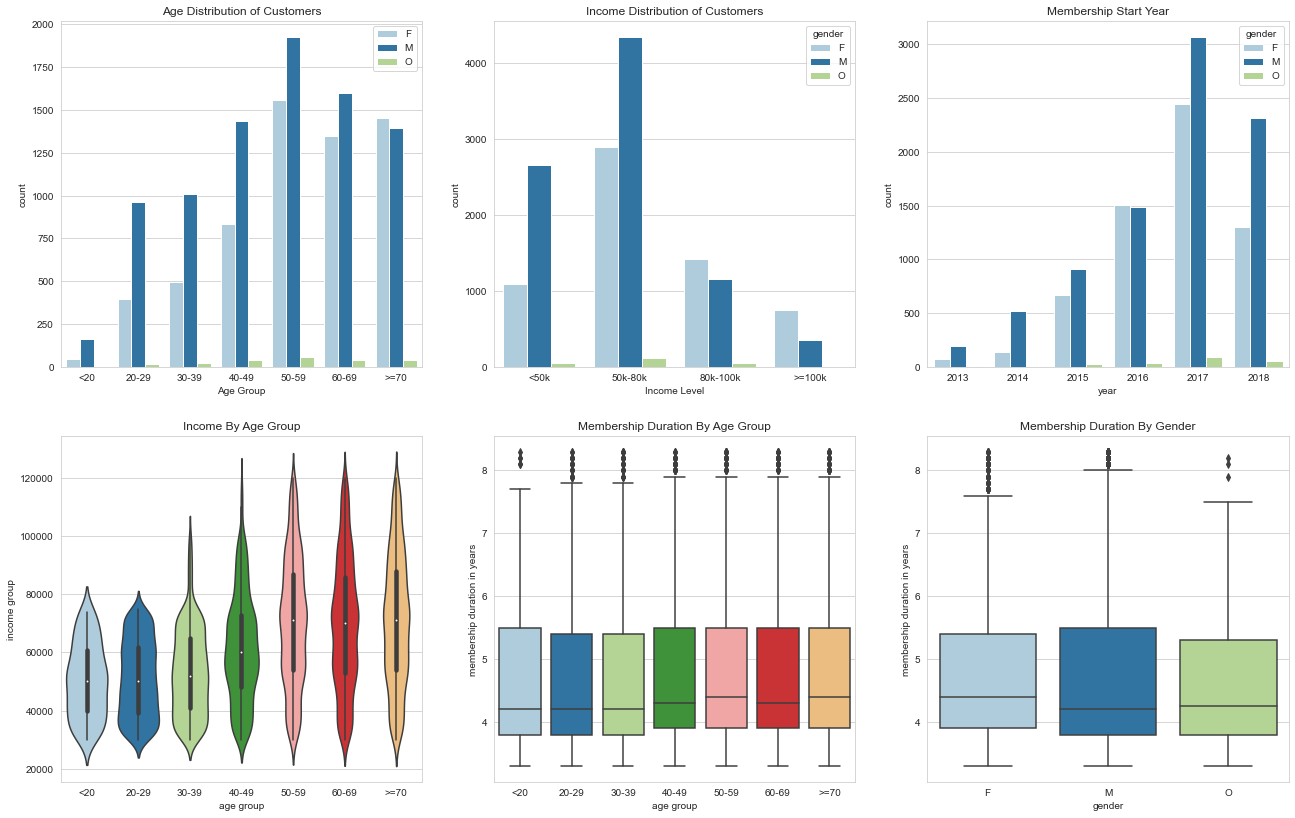

In [59]:
# Visualize data by age_groups, income_group, year after cleaned Profile data

plt.figure(figsize = [22,14])
age_order = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '>=70']
income_order = ['<50k', '50k-80k', '80k-100k', '>=100k']

sns.set_style("whitegrid")
sns.set_palette("Paired")
plt.subplot(2,3,1)
sns.countplot(data = profile, x = 'age_group', hue = 'gender', order = age_order)
plt.legend(loc='upper right')
plt.title('Age Distribution of Customers')
plt.ylabel('count')
plt.xlabel('Age Group');

plt.subplot(2,3,2)
sns.countplot(data = profile, x = 'income_group', hue = 'gender', order = income_order)
plt.title('Income Distribution of Customers')
plt.ylabel('count')
plt.xlabel('Income Level');

plt.subplot(2,3,3)
sns.countplot(data = profile, x = 'member_since', hue = 'gender')
plt.title('Membership Start Year')
plt.ylabel('count')
plt.xlabel('year');

plt.subplot(2,3,4)
sns.violinplot(data = profile, x = 'age_group', y = 'income', order = age_order)
plt.title('Income By Age Group')
plt.ylabel('income group')
plt.xlabel('age group');

plt.subplot(2,3,5)
sns.boxplot(data = profile, x = 'age_group', y = 'membership_in_years', order = age_order)
plt.title('Membership Duration By Age Group')
plt.ylabel('membership duration in years')
plt.xlabel('age group');

plt.subplot(2,3,6)
sns.boxplot(data = profile, x = 'gender', y = 'membership_in_years')
plt.title('Membership Duration By Gender')
plt.ylabel('membership duration in years')
plt.xlabel('gender');


In [21]:
profile.sample(5)

,gender,age,id,became_member_on,income,age_group,income_group,membership_in_years,member_since
16735,M,48,18502222e97f4a03b15b0e8e0768544d,2013-12-25,56000.0,40-49,50k-80k,7.9,2013
14430,M,42,a0899ec8221b4e37825a350b2179534c,2018-04-23,54000.0,40-49,50k-80k,3.6,2018
12027,M,64,4a3579f62ba94e8eb1cc6657d51a5deb,2015-12-24,89000.0,60-69,80k-100k,5.9,2015
8065,M,53,18a4097b43f548c3a34efb2699fdcfcb,2014-02-20,66000.0,50-59,50k-80k,7.7,2014
12756,M,54,d49af5885cad4f6d89bb9c2ad1d85997,2018-03-25,36000.0,50-59,<50k,3.6,2018


In [22]:
profile.id.nunique()

14825

### profile dataset EDA Insight
- 17000 rows and 5 columns in total
- 2175 missing values in the id and income column (removed)
- No duplicated id, means no duplicated customer record
- Become_memeber_on column needs to convert to datetime type and add a new column: membership_in_years for membership duration calculated in years(done)
- age column contains outliers(age=118), which seems not true in reality (removed)
- Add a new column: age_group column to categorize customer based on age (done)
- Add a new column: income_group column to categorize customer based on income (done)

## transcript dataset

In [23]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [24]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [25]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [26]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [27]:
print('The number of unique customer id in transcript: {}'.format(transcript.person.nunique()))
print('The number of unique customer id in profile: {}'.format(profile.id.nunique()))
print('The numer of ids in both transcript and profile datasets: {}'\
      .format(len(set(transcript.person.unique()).intersection(set(profile.id.unique())))))

The number of unique customer id in transcript: 17000
The number of unique customer id in profile: 14825
The numer of ids in both transcript and profile datasets: 14825


In [28]:
# Check keys in value column

value_keys = transcript['value'].apply(lambda x: x.keys())
print(value_keys.value_counts())

(amount)              138953
(offer id)            134002
(offer_id, reward)     33579
Name: value, dtype: int64


In [29]:
def clean_value_col(df=transcript):
    '''
    INPUT:
    df - a dataframe contains value column
    
    OUTPUT:
    df - a dataframe with new columns: offer_id, reward, spent separated from value column
    '''
    # Extract key-values from value column and create new columns
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id') if x.get('offer id')==None else x.get('offer id'))
    df['spent'] = df['value'].apply(lambda x: x.get('amount'))
    df['gained'] = df['value'].apply(lambda x: x.get('reward'))
    
    # Drop 'value' column 
    df.drop('value', axis=1, inplace=True)
    
    # Replace NANs
    df.fillna(0 , inplace=True)
    
    return df

transcript = clean_value_col()

In [30]:
# Check duplicates
# A duplicate is defined as person, offer_id, event, time, spent are all same

print('The number of duplicates: {}'.format(transcript[transcript.duplicated(subset=['person','offer_id','event','time','spent'])].shape[0]))
transcript = transcript.drop_duplicates(subset=['person','offer_id','event','time','spent'])
transcript.shape

The number of duplicates: 397


(306137, 6)

In [31]:
transcript.sample(5)

,person,event,time,offer_id,spent,gained
195018,e7d5895029ec4bbe859a9bf13a0ff13a,transaction,474,0,17.97,0.0
306517,3408fd05c781401f8442fb6dbaaea9c7,transaction,714,0,11.70,0.0
202966,8df3bb97a75a47b08c87d2cc3187eeb7,offer received,504,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,0.0
144426,ccd97c93c5544596847e18af79d555ba,offer completed,384,fafdcd668e3743c1bb461111dcafc2a4,0.00,2.0
240025,637b71c75f1444e38e2e361746590e5a,transaction,558,0,7.15,0.0


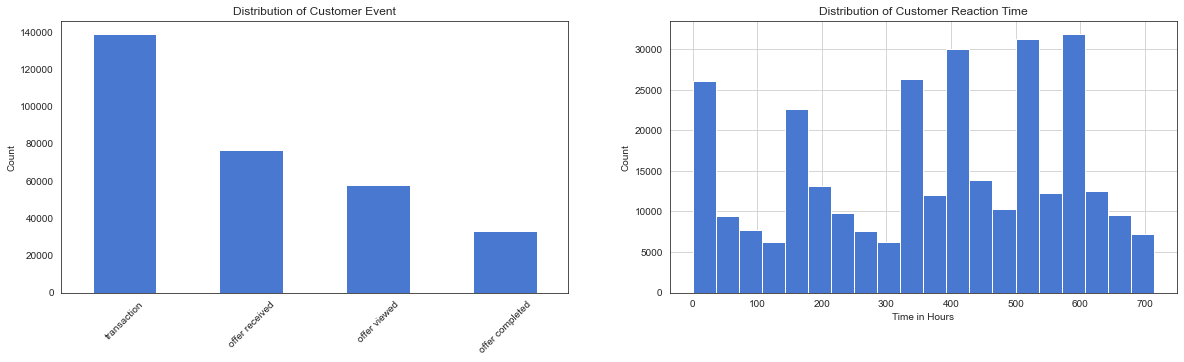

In [56]:
plt.figure(figsize=[20,5])
color = sns.color_palette()[0]
sns.set_style("white")

plt.subplot(1,2,1)
transcript.event.value_counts().plot(kind='bar', color = color)
plt.title('Distribution of Customer Event')
plt.ylabel('Count')
plt.xticks(rotation=45);

plt.subplot(1,2,2)
transcript.time.hist(bins=20, color=color)
plt.title('Distribution of Customer Reaction Time')
plt.ylabel('Count')
plt.xlabel('Time in Hours');


In [33]:
# Combine three datasets together

# merge transtript and portfolio
portfolio = portfolio.rename(columns={'id': 'offer_id'})
starbucks = pd.merge(transcript, portfolio, on='offer_id', how='left')

# merge with profile
profile = profile.rename(columns={'id': 'person'})
starbucks = pd.merge(starbucks, profile, on='person', how='left')

starbucks.shape

(306137, 19)

In [34]:
# Check missing value percentage in merged dataset starbucks

starbucks.isnull().sum() / starbucks.shape[0]

person                 0.000000
event                  0.000000
time                   0.000000
offer_id               0.000000
spent                  0.000000
gained                 0.000000
reward                 0.453892
channels               0.453892
difficulty             0.453892
duration               0.453892
offer_type             0.453892
gender                 0.110241
age                    0.110241
became_member_on       0.110241
income                 0.110241
age_group              0.110241
income_group           0.110241
membership_in_years    0.110241
member_since           0.110241
dtype: float64

In [35]:
starbucks.sample(3)

,person,event,time,offer_id,spent,gained,reward,channels,difficulty,duration,offer_type,gender,age,became_member_on,income,age_group,income_group,membership_in_years,member_since
283778,d9bd7e93629d4a31a1ee88d082ca5844,offer completed,630,ae264e3637204a6fb9bb56bc8210ddfd,0.00,10.0,10.0,"[email, mobile, social]",10.0,7.0,bogo,M,80.0,2015-09-26,70000.0,>=70,50k-80k,6.1,2015.0
37549,6ab082b797c54160b62417326d5f0c39,transaction,78,0,13.89,0.0,NaN,NaN,NaN,NaN,NaN,F,59.0,2017-10-23,57000.0,50-59,50k-80k,4.1,2017.0
250452,acc7e5f4e14a4297a80ec65c170c9c4d,offer received,576,ae264e3637204a6fb9bb56bc8210ddfd,0.00,0.0,10.0,"[email, mobile, social]",10.0,7.0,bogo,F,72.0,2017-01-13,87000.0,>=70,80k-100k,4.8,2017.0


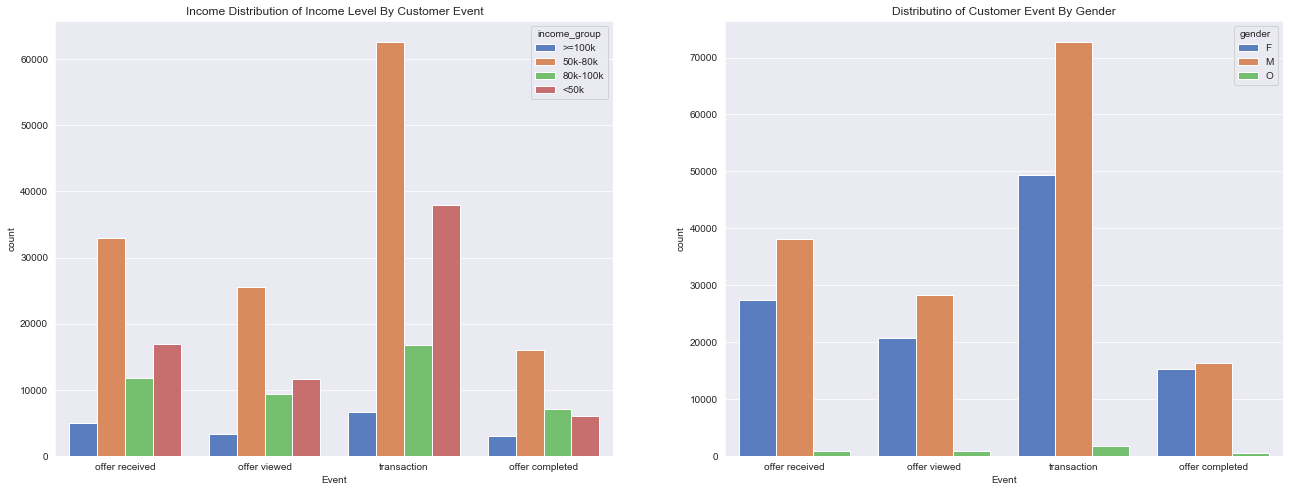

In [57]:
# Visualize combined data

plt.figure(figsize = [22,8])

sns.set_style("darkgrid")
sns.set_palette("muted")

plt.subplot(1,2,1)
sns.countplot(data = starbucks, x = 'event', hue = 'income_group')
plt.title('Income Distribution of Income Level By Customer Event')
plt.ylabel('count')
plt.xlabel('Event');

plt.subplot(1,2,2)
sns.countplot(data = starbucks, x = 'event', hue = 'gender')
plt.title('Distributino of Customer Event By Gender')
plt.ylabel('count')
plt.xlabel('Event');

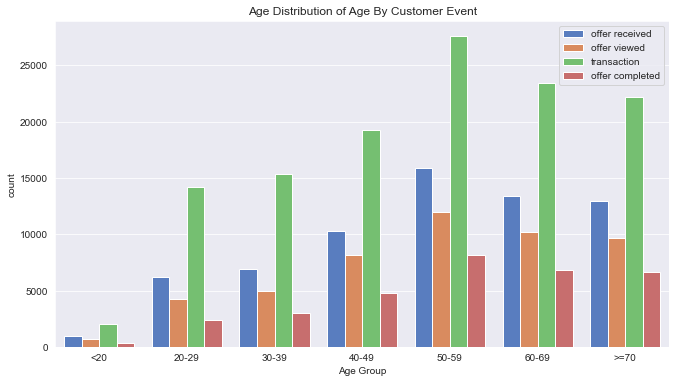

In [58]:
plt.figure(figsize=[11,6])
sns.countplot(data = starbucks, x = 'age_group', hue = 'event', order = age_order)
plt.legend(loc='upper right')
plt.title('Age Distribution of Age By Customer Event')
plt.ylabel('count')
plt.xlabel('Age Group');

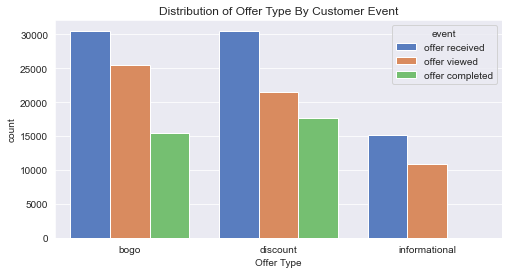

In [55]:
# Explore offer related records

# Make a subset without 'transaction' even, which is not linked to any offer_id 

plt.figure(figsize=[8,4])
sns.countplot(data = starbucks[starbucks['event'] != 'transaction'], x = 'offer_type', hue = 'event')
plt.title('Distribution of Offer Type By Customer Event')
plt.ylabel('count')
plt.xlabel('Offer Type');


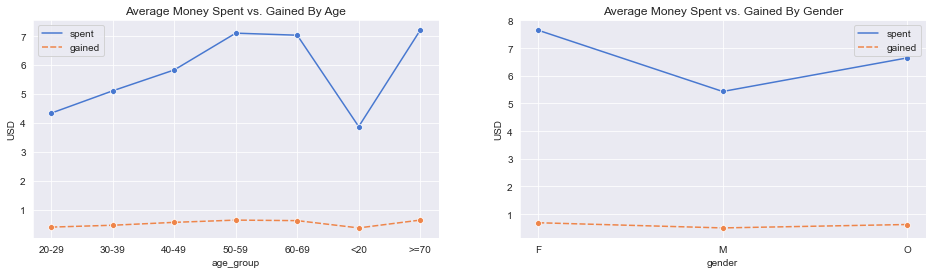

In [54]:
# Explore money spent vs. gained

plt.figure(figsize=[16,4])

plt.subplot(1,2,1)
spent_by_age = starbucks.dropna(subset=['age_group']).groupby('age_group').spent.mean()
gained_by_age = starbucks.dropna(subset=['age_group']).groupby('age_group').gained.mean()
money_age_group = pd.concat([spent_by_age, gained_by_age], axis=1)
sns.lineplot(data = money_age_group, marker = 'o')
plt.title('Average Money Spent vs. Gained By Age')
plt.ylabel('USD');

plt.subplot(1,2,2)
spent_by_gender = starbucks.dropna(subset=['gender']).groupby('gender').spent.mean()
gained_by_gender = starbucks.dropna(subset=['gender']).groupby('gender').gained.mean()
money_gender = pd.concat([spent_by_gender, gained_by_gender], axis=1)
sns.lineplot(data = money_gender, marker = 'o')
plt.title('Average Money Spent vs. Gained By Gender')
plt.ylabel('USD');


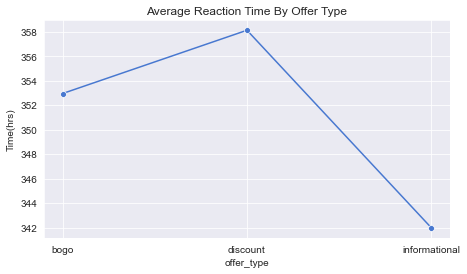

In [67]:
# Explore time

plt.figure(figsize=[16,4])
sns.set_style("darkgrid")
sns.set_palette("muted")

# plt.subplot(1,2,1)
# time_by_age = starbucks.dropna(subset=['age_group']).groupby('age_group').time.mean()
# sns.lineplot(data = time_by_age, marker = 'o', order=age_order)
# plt.title('Average Reaction Time By Age')
# plt.ylabel('Time(hrs)');
# #plt.savfig('avg_time_age.png');

plt.subplot(1,2,2)
time_by_offer = starbucks.dropna(subset=['offer_type']).groupby('offer_type').time.mean()
sns.lineplot(data = time_by_offer, marker = 'o')
plt.title('Average Reaction Time By Offer Type')
plt.ylabel('Time(hrs)');
#plt.savfig('avg_time_offer.png');

### transcript dataset EDA Insight

- 306534 rows and 4 columns in total, no missing values
- 14825 out of 17000 customer ids from transcript dataset exist in profile dataset. 
- value column needs to split into several columns for each key-value pair in the series(done)
- There are duplicates regarding to the same pereson, offer_id, spent, event, time. (removed)
- Combine three dataset together for integrated analysis. portfolio dataset shares offer_id with transcript dataset. transcript dataset shares customer_id with profile dataset.(done, new merged dataset - starbucks)

# Data Preparation


1. From above data understanding, we know that there are 4 types of events: offer completed, offer received, offer viewed and transaction. But our data shows that we do not have any offer_id associated with transactions, because they are not recorded in the transcript event data. Thus, the first objective in data preprocessing is to define a methodology to assign offer_ids to specific transactions.

2. Among three types of offers, BOGO and discount offers require customer to spend a certain amount of money in order to achieve the reward. On the other hand, informational offer that no need to spend money and no reward will be generated. The approach of how offers will be converted are different showed as belows:

  - BOGO and discount offer: offer received -> offer viewed -> offer completed

  - informational offer: offer received -> offer viewed 
  
3. We noticed the data with event type in 'transaction' is not linked to a specific offer, which we don't have a clear indicator of which offer it is converted from. Therefore, we need to filter out. 


In [40]:
def data_processing(df=starbucks):
    '''
    INPUT:
    df - a dataframe combined three datasets(transcript, profile, portfolio)
    
    OUTPUT:
    clean_df - a clean df for modeling
    
    data processing steps:
      1. filter out unuseful data, including drop records missing values in gender,age,income, member_since, etc.
      2. label encoding for feature engineering
      3. rename column name
      3. drop unuseful columns

    '''
    # Filter out 'transaction' records, which are not linked to any offer_id
    clean_df = df[df['event'] != 'transaction']
    clean_df.dropna(how='any', inplace=True)
    
    # Drop duplicates based person, offer_type, event, time, spent
    clean_df = clean_df.drop_duplicates(subset=['person','offer_type','event','time','spent'])
    
    # label encoding 
    clean_df = clean_df.join(clean_df.channels.str.join('|').str.get_dummies())  # split channels column
    clean_df = clean_df.join(pd.get_dummies(clean_df[['event','age_group','gender']]))
    
    # rename column name
    clean_df = clean_df.rename(columns={'event_offer completed':'event_offer_completed', 'event_offer received':'event_offer_received',\
                           'vent_offer viewed':'vent_offer_viewed'})
    
    # drop columns
    clean_df = clean_df.drop(['person','event','offer_id','channels','gender','age','age_group',\
                      'income_group', 'member_since', 'became_member_on'], axis=1)
    
    return clean_df

clean_df = data_processing(starbucks)
    

/Users/Bella/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [41]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147293 entries, 0 to 306130
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   time                   147293 non-null  int64  
 1   spent                  147293 non-null  float64
 2   gained                 147293 non-null  float64
 3   reward                 147293 non-null  float64
 4   difficulty             147293 non-null  float64
 5   duration               147293 non-null  float64
 6   offer_type             147293 non-null  object 
 7   income                 147293 non-null  float64
 8   membership_in_years    147293 non-null  float64
 9   email                  147293 non-null  int64  
 10  mobile                 147293 non-null  int64  
 11  social                 147293 non-null  int64  
 12  web                    147293 non-null  int64  
 13  event_offer_completed  147293 non-null  uint8  
 14  event_offer_received   147293 non-nu

In [42]:
clean_df.sample(3)

,time,spent,gained,reward,difficulty,duration,offer_type,income,membership_in_years,email,...,age_group_20-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_<20,age_group_>=70,gender_F,gender_M,gender_O
1921,0,0.0,0.0,5.0,20.0,10.0,discount,82000.0,6.8,1,...,0,0,0,1,0,0,0,0,1,0
252672,576,0.0,0.0,5.0,20.0,10.0,discount,70000.0,3.8,1,...,0,0,0,0,1,0,0,0,1,0
251714,576,0.0,0.0,5.0,20.0,10.0,discount,69000.0,4.1,1,...,0,0,0,1,0,0,0,0,1,0


# Modeling

The goal is to predict the best match of offer_type to give to a customer. The output should be discrete variables. Therefore, we choose classification models. Here, we will run three different models and pick the most optimize one.

### Three ML algorithms:
1. Decision Trees
2. Random Forest
3. K Nearest Neighbors(KNN)

Since we use classification models, accuracy is the goal to achieve. There are some metrics provided by sklearn libary to measure the accuracy: 

### Metrics:
1. Accuracy Score: the percent of correct predictions 
2. Confusion Matrix: a way to express how many of a classifier’s predictions were correct, and when incorrect, where the classifier got confused. 
3. Classification Report(Precision, F1-Score, Recall):
    - Precision: the number of correctly identified members among the class.
    - Recall: the number of class you find over the whole number of element of this class
    - F1 Score: harmonic mean of Precision and Recall. F1 = 2 * (precision * recall) / (precision + recall)

In [43]:
def data_classification_modeling(model, clean_df, target_var='offer_type'):
    '''
    INPUT:
    model - a ML algorithm
    clean_df - a clean dataframe generated from data_processing
    target_var - the prediction target variable
    
    OUTPUT:
    result_df - a dataframe contains the scores associatd with training and testing data set
    '''
    # Split dataset for training and testing

    X = clean_df.drop(target_var, axis=1)
    y = clean_df[target_var]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    print('Training data Shape X: {}, y: {}'.format(X_train.shape, y_train.shape))
    print('Testing data Shape X: {}, y: {}'.format(X_test.shape, y_test.shape) )
    
    # Run prediction model
    results = {}
    
    # Fit the model to the training data:
    model.fit(X_train, y_train)
    
    # predict on the testing data:
    y_pred_test = model.predict(X_test)

    # Confusion matrix:
    #confusion_matrix(y_pred_test, y_test)
    
    # Accuracy for testing data:
    results['test accuracy'] = accuracy_score(y_pred_test, y_test)
    
    # F-score on testing data:
    results['f1_score'] = fbeta_score(y_test, y_pred_test, beta = 0.5, average='weighted')
    results['precision'] = precision_score(y_test, y_pred_test, average='micro')    
    results['recall'] = recall_score(y_test, y_pred_test, average='micro')
    
    # ROC Score
    #results['roc'] = roc_auc_score(y_test, y_pred_test).str
    
    result_df = pd.DataFrame(results, index=range(1)) 
    
    return result_df

In [44]:
# Decision Tree

decision_tree = DecisionTreeClassifier(random_state = 42)
dt_score = data_classification_modeling(decision_tree, clean_df, 'offer_type')
print('Deecisin Tree Prediction Score:')
dt_score

Training data Shape X: (117834, 25), y: (117834,)
Testing data Shape X: (29459, 25), y: (29459,)
Deecisin Tree Prediction Score:


,test accuracy,f1_score,precision,recall
0,1.0,1.0,1.0,1.0


In [45]:
#Ranmdom Forest

random_forest = RandomForestClassifier(random_state = 42)
rf_score = data_classification_modeling(random_forest, clean_df, 'offer_type')
print('Random Forest Prediction Score:')
rf_score

Training data Shape X: (117834, 25), y: (117834,)
Testing data Shape X: (29459, 25), y: (29459,)
Random Forest Prediction Score:


,test accuracy,f1_score,precision,recall
0,1.0,1.0,1.0,1.0


In [46]:
# K Nearest Neighbors 

kneighbors = KNeighborsClassifier(n_neighbors=10, leaf_size=30)
knn_score = data_classification_modeling(kneighbors, clean_df, 'offer_type')
print('KNN Prediction Score:')
knn_score

Training data Shape X: (117834, 25), y: (117834,)
Testing data Shape X: (29459, 25), y: (29459,)
KNN Prediction Score:


,test accuracy,f1_score,precision,recall
0,0.896195,0.897877,0.896195,0.896195


# Eveluation & Refinement

The scores for Desicion Tree and Random Forest are 'pretty'100% accuracy, which seems not real, could be overfitting.
The KNeighbors Classifier has about 89% accuracy. Therefore, we choose KNN to proceed optimization in further.

### Hyperparameter Tuning for K Knearest Neighbors Model
(Due to the resource limitation of Local Machine) We choose several options for leaf_size and n_neighbors, instead of a larger range to run the process of finding the best match for the classification model.

GridSearchCV is used to run exhaustive search over specified parameter values for an estimator.

In [49]:
X = clean_df.drop('offer_type', axis=1)
y = clean_df['offer_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

leaf_size = [5,10,30]
n_neighbors = [3, 5,10]

# Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors)

# Create new KNN object
knn_2 = KNeighborsClassifier()

# Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=5, verbose=True)

# Fit the model
best_model = clf.fit(X_train, y_train)

#Print The value of best Hyperparameters
best_leaf_size = best_model.best_estimator_.get_params()['leaf_size']
best_n_neighbors = best_model.best_estimator_.get_params()['n_neighbors']
print('Best leaf_size:', best_leaf_size)
print('Best n_neighbors:', best_n_neighbors)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best leaf_size: 5
Best n_neighbors: 3


In [50]:
# Optimized Model

best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, leaf_size=best_leaf_size)
best_score = data_classification_modeling(best_knn, clean_df, 'offer_type')
print('KNN Prediction Score:')
best_score

Training data Shape X: (117834, 25), y: (117834,)
Testing data Shape X: (29459, 25), y: (29459,)
KNN Prediction Score:


,test accuracy,f1_score,precision,recall
0,0.929597,0.93025,0.929597,0.929597


# Conclusion


#### Q1. What kind of offers does Starbucks provide? What characristics does each offer type have? 
  - There are three types of offers: BOGO, discount and informational offer.
  - There are more BOGO and discount offers than informational offer.
  - Informational offer doesn't require to spend money and no reward as a result, and it lasts shortest time about 3 days.
  - BOGO is the best promotion offer to customers - cost less than discount to get more reward. It is ususally available for about 6 days, which is shorter than discount offers. 
  
#### Q2. What are the demographic characteristics of members?
  - Gender: There are more male than female in members
  - Age: most members are between age 21-70, especially a large group of those are between 50-60. Only a small part of members are under 20. The number of male and female at the age of 20s and 30s are quite close.
  - Income: It seems people whose annual income between 50k-80k are more likely to become a Starbucks member. While there are much more male member than female in who make less than 80k a year, we see there are more female member in the same income level above 80k a year. The income distribution of members under 40 are almost the same, compared to the older members.
  - Membership: There are no obvious difference of average membership duration among age groups. Female members have longer membership duration in average. As the number of members grows year over year, it is always more male members than female members, except in year 2016. We see there are a little bit more female join Starbucks membership.
  
  
#### Q3. How different do people react to the different promotion offers(transaciton characteristics)?
 - BOGO and Discunt type are sent to similar amount of customers. It turns out that more people completed discount type offer than BOGO type, while BOGO offer are viewed by more people than discount offer.
 - There are less percentage of people from 30-39 age group to complet offers.
 - Males spent much less money than females, but still gained simiar rewards.
 - Discount type offer takes longest for customer to make reaction.


### Prediction 
#### Q4. Can we build a prediction engine to help determine what offer we should send to each customer? 
The KNN algorithm with leaf_size=5 and n_neighbors=3 turns out to be the best model to predict the offer type to send to a customer, with the accuracy about 93%.

# Future Inprovement

- Find a better approach to measure the convertion of informational offer (maybe link to a transaction)
- Fill missing value in gender/income/age instead of drop the rows with those values missing
- Go deeper to the modeling part, such as try addtional models(SVM, etc). If possible, find better resource(Virtual Machine) to run refinement, find the most optimized model. Learn more about Machine Learning algorithm to consolidate the conclusion.
- Extend analysis scope to the respond rate from customer as well as building the prediction engine.